In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import optuna

from functions.clean import revert, write_predictions
from functions.distance import get_distance_coordinates, norm_features, PCA_plot

# Prepare Data

In [2]:
# category_5/2 data 
df_train_2 = pd.read_csv("../data/train_prepared_category_6.csv")
df_test_2 = pd.read_csv("../data/test_prepared_category_6.csv")

# category_6 data
df_train_4 = pd.read_csv("../data/train_prepared_category_6.csv")
df_test_4 = pd.read_csv("../data/test_prepared_category_6.csv")

In [3]:
# Keep originals
D2_train = df_train_2.copy()
D2_test = df_test_2.copy()
D4_train = df_train_4.copy()
D4_test = df_test_4.copy()

In [4]:
df_train_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Columns: 110 entries, Unnamed: 0 to elevator_no
dtypes: float64(19), int64(89), object(2)
memory usage: 19.5+ MB


In [5]:
df_train_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Columns: 110 entries, Unnamed: 0 to elevator_no
dtypes: float64(19), int64(89), object(2)
memory usage: 19.5+ MB


In [6]:
# First 2 runs on category_3, next on category_5

drop_features_2 = ["Unnamed: 0",
                   "id", 
                   "street", 
                   "address",
                   "building_id"]

D2_train = D2_train.drop(drop_features_2, axis=1)
D2_test = D2_test.drop(drop_features_2, axis=1)

D2_train = D2_train.drop("price", axis=1)
features_2 = D2_train.columns.values.tolist()

In [7]:
# First 2 runs on category_4, next on category_5 modified

drop_features_4 = ["Unnamed: 0",
                   "id", 
                   "street", 
                   "address",
                   "building_id",
                   "phones_0.0", "phones_1.0", "phones_2.0", "phones_nan",
                   "layout_0.0", "layout_1.0", "layout_2.0", "layout_nan",
                   "new_0.0", "new_1.0", "new_nan"]

D4_train = D4_train.drop(drop_features_4, axis=1)
D4_test = D4_test.drop(drop_features_4, axis=1)

D4_train = D4_train.drop("price", axis=1)
features_4 = D4_train.columns.values.tolist()

In [8]:
"""
# Currently done when preparing category_5 data in clean.py

imputor=IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

imp1 = imputor.fit_transform(D2_train)
imp2 = imputor.fit_transform(D2_test)

D2_train = pd.DataFrame(imp1, columns=features_2)
D2_test = pd.DataFrame(imp2, columns=features_2)

"""

"\n# Currently done when preparing category_5 data in clean.py\n\nimputor=IterativeImputer(\n    estimator=BayesianRidge(),\n    random_state=42,\n    imputation_order='ascending', \n    max_iter=100,\n    tol=1e-5)\n\nimp1 = imputor.fit_transform(D2_train)\nimp2 = imputor.fit_transform(D2_test)\n\nD2_train = pd.DataFrame(imp1, columns=features_2)\nD2_test = pd.DataFrame(imp2, columns=features_2)\n\n"

In [9]:
# Real prices
y_train_2 = df_train_2["price"].copy()
y_train_4 = df_train_4["price"].copy()

# Log prices (ln) (used in first and second run)
#y_train_2 = np.log(y_train_2)
#y_train_4 = np.log(y_train_4)
# Log 10 prices (log10) (used in third run)
y_train_2 = np.log10(y_train_2)
y_train_4 = np.log10(y_train_4)

In [10]:
D2_train.head()

,area_total,area_kitchen,area_living,floor,rooms,ceiling,latitude,longitude,constructed,stories,...,district_5.0,district_6.0,district_7.0,district_8.0,district_9.0,district_10.0,district_11.0,district_nan,elevator,elevator_no
0,-0.259939,-0.007962,-0.246552,-0.837486,-0.175954,-0.057242,55.817557,37.732359,0.796153,-0.767515,...,0,0,0,0,0,0,0,0,1,0
1,0.230930,-0.388730,-0.787980,1.085119,0.753302,-0.059725,55.725133,37.775263,0.709001,0.658938,...,0,0,0,0,0,0,0,0,1,0
2,0.069012,-0.997958,-0.765686,0.364142,0.753302,-0.057242,55.725133,37.775263,0.796153,-0.232595,...,0,0,0,0,0,0,0,0,1,0
3,0.230930,-0.236423,-0.724282,1.085119,0.753302,-0.055312,55.725133,37.775263,0.752577,0.658938,...,0,0,0,0,0,0,0,0,1,0
4,0.060489,0.438011,0.450934,-0.236672,-0.175954,0.027425,55.734643,37.698798,0.578273,-0.232595,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#D4_train.info()

# Prepare Analysis - Hyperparameter Tuning

In [ ]:
X = D4_train.copy()
y = y_train_4.copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

# Test Models

# Hyperparameter testing on cateogry_4 data and LGBM

In [ ]:
def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 50, 74)
    max_depth = trial.suggest_int('max_depth', 60, 100)
    n_jobs = trial.suggest_int('n_jobs', 3, 7)
    n_estimators = trial.suggest_int('n_estimators', 3500, 4120)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.44, 0.64)
    subsample = trial.suggest_uniform('subsample', 0.9, 1)
    learning_rate = trial.suggest_uniform('learning_rate', 0.02, 0.06)

    clf = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth, 
        random_state=42,
        metric='rmse',
        n_jobs=n_jobs, 
        n_estimators=n_estimators,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        learning_rate=learning_rate
    )

    clf.fit(X_train, y_train)
    lgbm_prediction = clf.predict(X_test, num_iteration=clf.best_iteration_)
    lgbm_prediction = np.exp(lgbm_prediction)

    return np.sqrt(mean_squared_log_error(lgbm_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

# Hyperparameter testing on category_2/5 data with general imputing using LGBM

In [ ]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
def objective_2(trial):
    num_leaves = trial.suggest_int('num_leaves', 50, 74)
    max_depth = trial.suggest_int('max_depth', 60, 100)
    n_jobs = trial.suggest_int('n_jobs', 3, 7)
    n_estimators = trial.suggest_int('n_estimators', 3500, 4120)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.44, 0.64)
    subsample = trial.suggest_uniform('subsample', 0.9, 1)
    learning_rate = trial.suggest_uniform('learning_rate', 0.02, 0.06)

    clf = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth, 
        random_state=42,
        metric='rmse',
        n_jobs=n_jobs, 
        n_estimators=n_estimators,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        learning_rate=learning_rate
    )

    clf.fit(X_train, y_train)
    lgbm_prediction = clf.predict(X_test, num_iteration=clf.best_iteration_)
    lgbm_prediction = np.exp(lgbm_prediction)

    return np.sqrt(mean_squared_log_error(lgbm_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective_2, n_trials=100)
print(study.best_trial)

# Optimizing XBOOST

# Tuning Category_4 data for XBOOST

In [ ]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
def objective(trial):
    base_score = trial.suggest_uniform('base_score', 0.6, 0.76)
    max_depth = trial.suggest_int('max_depth', 10, 14)
    n_jobs = trial.suggest_int('n_jobs', 14, 18)
    min_child_weight = trial.suggest_int('min_child_weight', 6, 10)
    n_estimators = trial.suggest_int('n_estimators', 1594, 2194)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.7, 0.86)
    subsample = trial.suggest_uniform('subsample', 0.73, 0.9)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.06)

    clf=xgboost.XGBRegressor(base_score=base_score, 
                             booster='gbtree', 
                             colsample_bylevel=1,
                             colsample_bynode=1, 
                             colsample_bytree=colsample_bytree,
                             gamma=0, 
                             gpu_id=-1, 
                             importance_type=None,
                             interaction_constraints='',
                             learning_rate=learning_rate, 
                             max_delta_step=0,
                             max_depth=max_depth, 
                             min_child_weight=min_child_weight,
                             monotone_constraints='()', 
                             n_estimators=n_estimators, 
                             n_jobs=n_jobs,
                             num_parallel_tree=1, 
                             predictor='auto', 
                             random_state=42, 
                             reg_alpha=0,
                             reg_lambda=1, 
                             scale_pos_weight=1, 
                             subsample=subsample, 
                             tree_method='exact',
                             validate_parameters=1, 
                             verbosity=None, 
                             objective='reg:squarederror',
                             enable_categorical=False)

    clf.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_train, y_train), (X_test, np.log(y_test))])
    xgboost_prediction = clf.predict(X_test)
    xgboost_prediction = np.exp(xgboost_prediction)

    return np.sqrt(mean_squared_log_error(xgboost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

# Tuning Category_2/5 autoimputed data for XBOOST

In [ ]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
def objective(trial):
    base_score = trial.suggest_uniform('base_score', 0.6, 0.76)
    max_depth = trial.suggest_int('max_depth', 10, 14)
    n_jobs = trial.suggest_int('n_jobs', 14, 18)
    min_child_weight = trial.suggest_int('min_child_weight', 6, 10)
    n_estimators = trial.suggest_int('n_estimators', 1594, 2194)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.7, 0.86)
    subsample = trial.suggest_uniform('subsample', 0.73, 0.9)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.06)

    clf=xgboost.XGBRegressor(base_score=base_score, 
                             booster='gbtree', 
                             colsample_bylevel=1,
                             colsample_bynode=1, 
                             colsample_bytree=colsample_bytree,
                             gamma=0, 
                             gpu_id=-1, 
                             importance_type=None,
                             interaction_constraints='',
                             learning_rate=learning_rate, 
                             max_delta_step=0,
                             max_depth=max_depth, 
                             min_child_weight=min_child_weight,
                             monotone_constraints='()', 
                             n_estimators=n_estimators, 
                             n_jobs=n_jobs,
                             num_parallel_tree=1, 
                             predictor='auto', 
                             random_state=42, 
                             reg_alpha=0,
                             reg_lambda=1, 
                             scale_pos_weight=1, 
                             subsample=subsample, 
                             tree_method='exact',
                             validate_parameters=1, 
                             verbosity=None, 
                             objective='reg:squarederror',
                             enable_categorical=False)

    clf.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_train, y_train), (X_test, np.log(y_test))])
    xgboost_prediction = clf.predict(X_test)
    xgboost_prediction = np.exp(xgboost_prediction)

    return np.sqrt(mean_squared_log_error(xgboost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

# Optimising CatBoost

In [ ]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

# Tune category_4 data for CatBoost

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1500, 2800)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    depth = trial.suggest_int('depth', 5, 12)
    bagging_temperature = trial.suggest_uniform('bagging_temperature', 0.05, 0.3)

    clf=CatBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        thread_count=-1,
        depth=depth,
        silent=True,
        random_state=42,
        bagging_temperature=bagging_temperature
    )

    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=10)
    cat_boost_prediction = clf.predict(X_test)
    cat_boost_prediction = np.exp(cat_boost_prediction)

    return np.sqrt(mean_squared_log_error(cat_boost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

# Tune category_2/5 imputed date for CatBoost

In [ ]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1500, 2800)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    depth = trial.suggest_int('depth', 5, 12)
    bagging_temperature = trial.suggest_uniform('bagging_temperature', 0.05, 0.3)

    clf=CatBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        thread_count=-1,
        depth=depth,
        silent=True,
        random_state=42,
        bagging_temperature=bagging_temperature
    )

    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=10)
    cat_boost_prediction = clf.predict(X_test)
    cat_boost_prediction = np.exp(cat_boost_prediction)

    return np.sqrt(mean_squared_log_error(cat_boost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

# Hyperparameter tuning Random Forest

In [ ]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 300, 400)
    #max_depth = trial.suggest_int("max_depth", 18, 32, log=True)
    #min_samples_split = trial.suggest_int('min_samples_split', 60, 120)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 25, 65)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 7000, 10000)
    #max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])

    clf=RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=None,
        #min_samples_split=min_samples_split,
        #min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=0.0,
        max_features='auto',
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=42,
        verbose=0,
        warm_start=False,
        ccp_alpha=0.0,
        max_samples=None
    )

    clf.fit(X_train, y_train)
    random_forest_prediction = clf.predict(X_test)
    random_forest_prediction = np.exp(random_forest_prediction)

    return np.sqrt(mean_squared_log_error(random_forest_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

In [ ]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 300, 400)
    #max_depth = trial.suggest_int("max_depth", 18, 32, log=True)
    #min_samples_split = trial.suggest_int('min_samples_split', 60, 120)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 25, 65)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 7000, 10000)
    #max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])

    clf=RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=None,
        #min_samples_split=min_samples_split,
        #min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=0.0,
        max_features='auto',
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=42,
        verbose=0,
        warm_start=False,
        ccp_alpha=0.0,
        max_samples=None
    )

    clf.fit(X_train, y_train)
    random_forest_prediction = clf.predict(X_test)
    random_forest_prediction = np.exp(random_forest_prediction)

    return np.sqrt(mean_squared_log_error(random_forest_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

# AdaBoost

In [ ]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 600, 1100)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.06)

    clf=AdaBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        loss='square',
        random_state=42
    )

    clf.fit(X_train, y_train)
    ada_boost_prediction = clf.predict(X_test)
    ada_boost_prediction = np.exp(ada_boost_prediction)

    return np.sqrt(mean_squared_log_error(ada_boost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

In [ ]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 600, 1100)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.06)

    clf=AdaBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        loss='square',
        random_state=42
    )

    clf.fit(X_train, y_train)
    ada_boost_prediction = clf.predict(X_test)
    ada_boost_prediction = np.exp(ada_boost_prediction)

    return np.sqrt(mean_squared_log_error(ada_boost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

# Run Models

# Run CatBoost on category_4

In [11]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [12]:
# Using optimized hyperparameter for complete category_4 data
modelCBR = CatBoostRegressor(n_estimators=2343,
                             learning_rate=0.058500478169372754,
                             thread_count=-1,
                             depth=12,
                             silent=True,
                             random_seed=42,
                             bagging_temperature=0.08070463240695834)

modelCBR.fit(X_train, y_train)
cat_prediction = modelCBR.predict(X_test)
cat_mse = round(mean_squared_error(cat_prediction, y_test), 5)
print('Test MSE:', cat_mse)
print("Test RMSE: ", np.sqrt(cat_mse))

Test MSE: 0.00958
Test RMSE:  0.09787747442593725


Text(0, 0.5, 'Ground Truth')

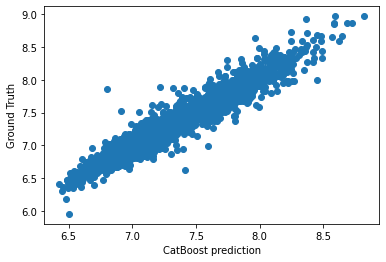

In [13]:
# Plot model performance (done on splitting test data)
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

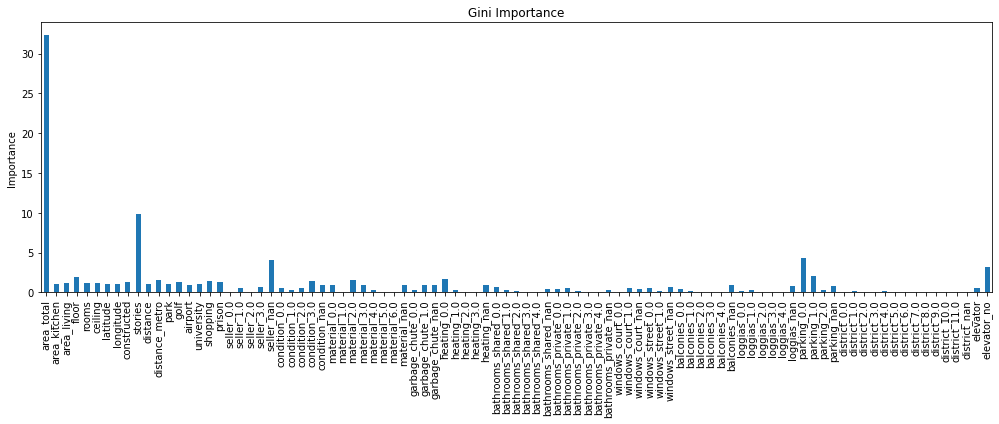

In [14]:
importances = modelCBR.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run CatBoost on category_2/5

In [15]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [16]:
# Using optimized hyperparameter for complete category_4 data
modelCBR = CatBoostRegressor(
    n_estimators=1968,
    learning_rate=0.05798827431610841,
    thread_count=-1,
    depth=12,
    silent=True,
    random_seed=42,
    bagging_temperature=0.1058370968938238
#     od_type="Iter"
)

modelCBR.fit(X_train, y_train)
cat_prediction = modelCBR.predict(X_test)
cat_mse = round(mean_squared_error(cat_prediction, y_test), 5)
print('Test MSE:', cat_mse)
print("Test RMSE: ", np.sqrt(cat_mse))

Test MSE: 0.00928
Test RMSE:  0.09633275663033837


Text(0, 0.5, 'Ground Truth')

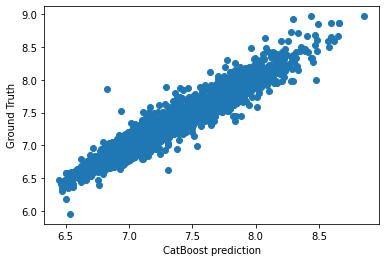

In [17]:
# Plot model performance (done on splitting test data)
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

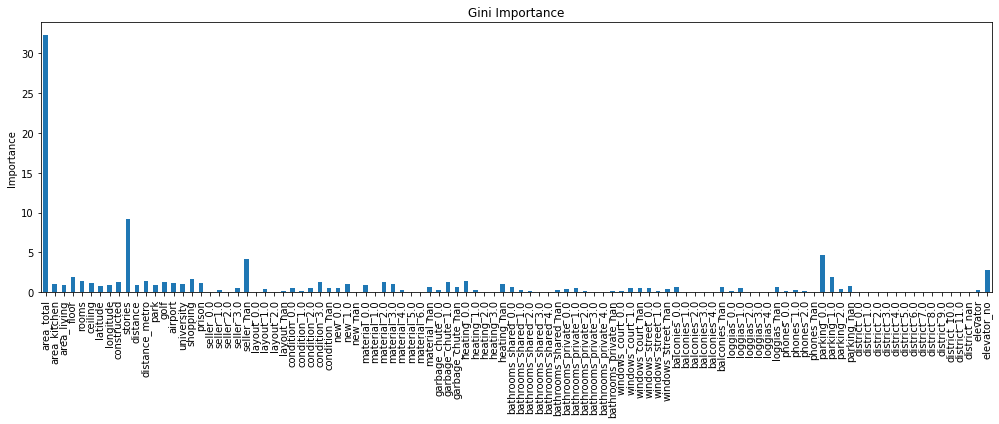

In [18]:
importances = modelCBR.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run XBoost on category_4

In [19]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [20]:
modelXGBR = xgboost.XGBRegressor(base_score=0.7041494982916056, 
                                 booster='gbtree', 
                                 colsample_bylevel=1,
                                 colsample_bynode=1, 
                                 colsample_bytree=0.7124067309329056,
                                 gamma=0, 
                                 gpu_id=-1, 
                                 importance_type=None,
                                 interaction_constraints='',
                                 learning_rate=0.03581837931328673, 
                                 max_delta_step=0,
                                 max_depth=12, 
                                 min_child_weight=7,
                                 monotone_constraints='()', 
                                 n_estimators=1731, 
                                 n_jobs=16,
                                 num_parallel_tree=1, 
                                 predictor='auto', 
                                 random_state=42, 
                                 reg_alpha=0,
                                 reg_lambda=1, 
                                 scale_pos_weight=1, 
                                 subsample=0.8941570357029943, 
                                 tree_method='exact',
                                 validate_parameters=1, 
                                 verbosity=None, 
                                 objective='reg:squarederror',
                                 enable_categorical=False)

modelXGBR.fit(X_train, y_train)
prediction = modelXGBR.predict(X_test)
mse = round(mean_squared_error(prediction, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.00899
Test RMSE:  0.09481561052906846


Text(0, 0.5, 'Ground Truth')

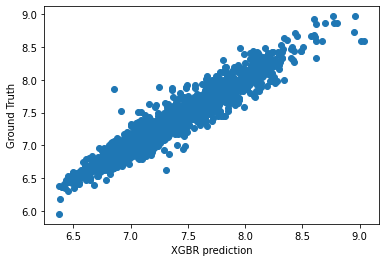

In [21]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('XGBR prediction')
plt.ylabel('Ground Truth')

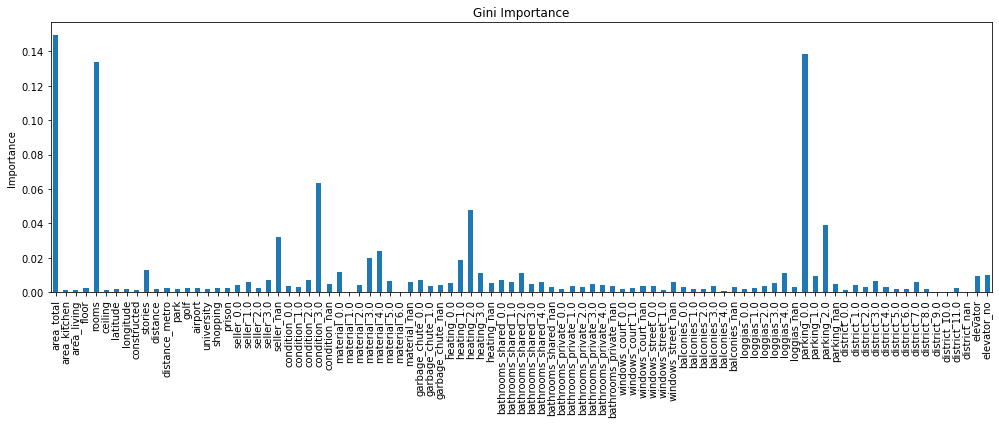

In [22]:
importances = modelXGBR.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run XBoost on category_2/5

In [23]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [24]:
modelXGBR = xgboost.XGBRegressor(base_score=0.743964276055796, 
                                 booster='gbtree', 
                                 colsample_bylevel=1,
                                 colsample_bynode=1, 
                                 colsample_bytree=0.840092711997448,
                                 gamma=0, 
                                 gpu_id=-1, 
                                 importance_type=None,
                                 interaction_constraints='',
                                 learning_rate=0.04098594100743038, 
                                 max_delta_step=0,
                                 max_depth=12, 
                                 min_child_weight=9,
                                 monotone_constraints='()', 
                                 n_estimators=2134, 
                                 n_jobs=15,
                                 num_parallel_tree=1, 
                                 predictor='auto', 
                                 random_state=42, 
                                 reg_alpha=0,
                                 reg_lambda=1, 
                                 scale_pos_weight=1, 
                                 subsample=0.7321278516386417, 
                                 tree_method='exact',
                                 validate_parameters=1, 
                                 verbosity=None, 
                                 objective='reg:squarederror',
                                 enable_categorical=False)

modelXGBR.fit(X_train, y_train)
prediction = modelXGBR.predict(X_test)
mse = round(mean_squared_error(prediction, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.0088
Test RMSE:  0.0938083151964686


Text(0, 0.5, 'Ground Truth')

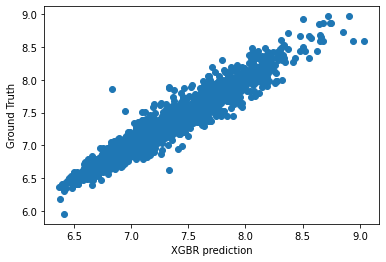

In [25]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('XGBR prediction')
plt.ylabel('Ground Truth')

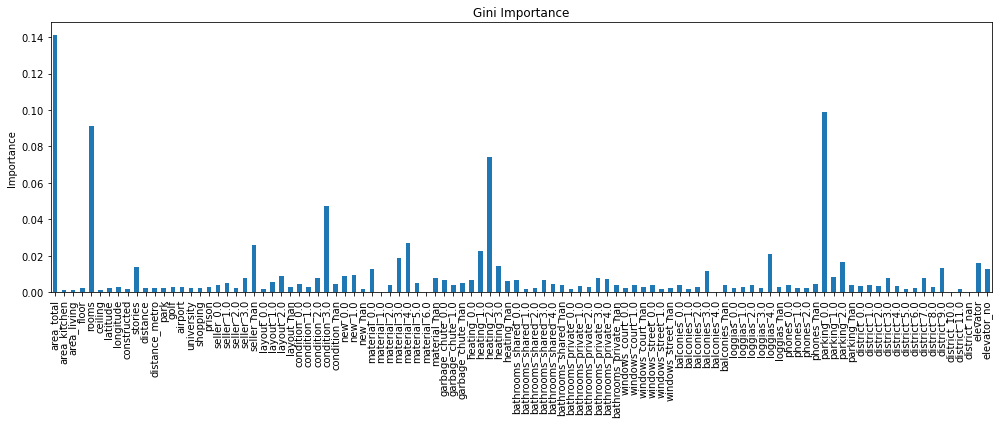

In [26]:
importances = modelXGBR.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run LGBM on category_4

In [27]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [28]:
modelLGBM = lgb.LGBMRegressor(num_leaves=72,
                              max_depth=79, 
                              random_state=42,
                              metric='rmse',
                              n_jobs=4, 
                              n_estimators=4059,
                              colsample_bytree=0.5924522364267432,
                              subsample=0.9984269177996842,
                              learning_rate=0.04557246091996505)

modelLGBM.fit(X_train, y_train)
prediction = modelLGBM.predict(X_test)
mse = round(mean_squared_error(prediction, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.00914
Test RMSE:  0.09560334722173697


Text(0, 0.5, 'Ground Truth')

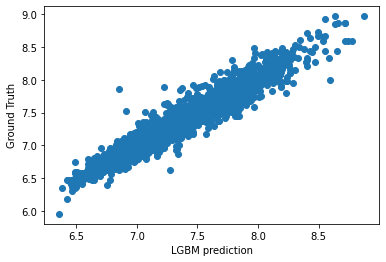

In [29]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

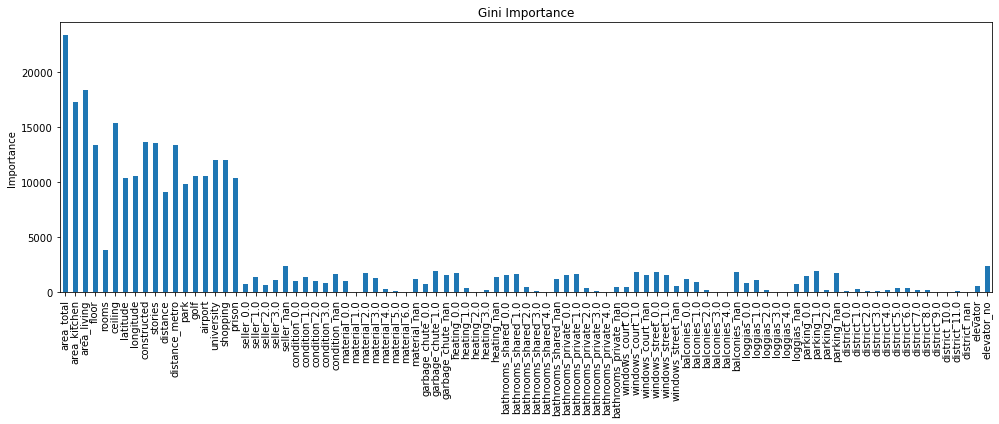

In [30]:
importances = modelLGBM.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run LGBM on category_2/5

In [31]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [32]:
modelLGBM = lgb.LGBMRegressor(num_leaves=66,
                              max_depth=89, 
                              random_state=42,
                              metric="rmse",
                              n_jobs=5, 
                              n_estimators=3618,
                              colsample_bytree=0.4884363488470012,
                              subsample=0.9200833605682563,
                              learning_rate=0.031095295589667282)

modelLGBM.fit(X_train, y_train)
prediction = modelLGBM.predict(X_test)
mse = round(mean_squared_error(prediction, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.00916
Test RMSE:  0.0957078889120432


Text(0, 0.5, 'Ground Truth')

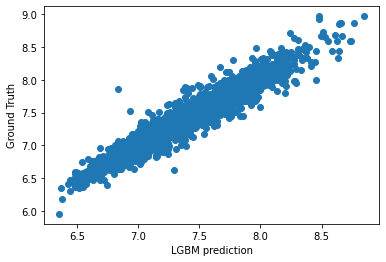

In [33]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

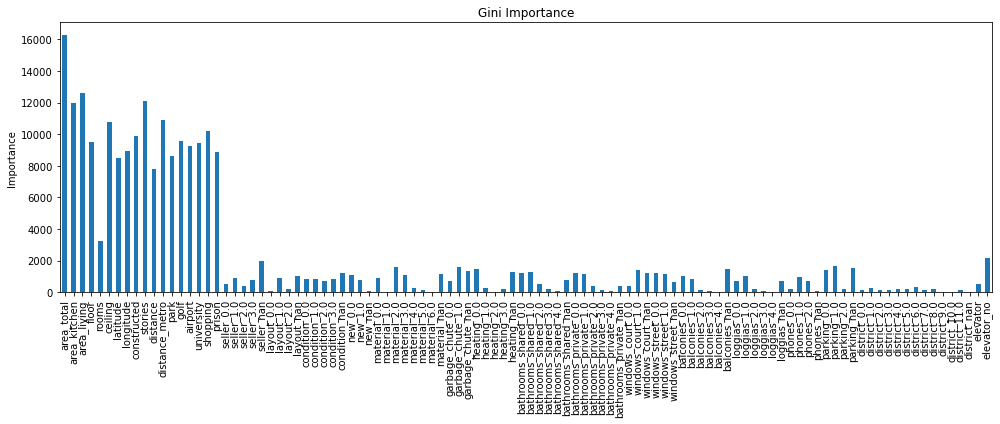

In [34]:
importances = modelLGBM.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run RandomForest on category_4

In [35]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [36]:
modelRF = RandomForestRegressor(n_estimators=362,
                                max_depth=None,
                                #min_samples_split=min_samples_split,
                                #min_samples_leaf=min_samples_leaf,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=7363,
                                min_impurity_decrease=0.0,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=None,
                                random_state=42,
                                verbose=0,
                                warm_start=False,
                                ccp_alpha=0.0,
                                max_samples=None)

modelRF.fit(X_train, y_train)
prediction = modelRF.predict(X_test)
mse = round(mean_squared_error(prediction, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.01276
Test RMSE:  0.11296016997154351


Text(0, 0.5, 'Ground Truth')

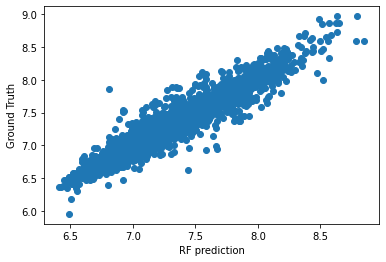

In [37]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('RF prediction')
plt.ylabel('Ground Truth')

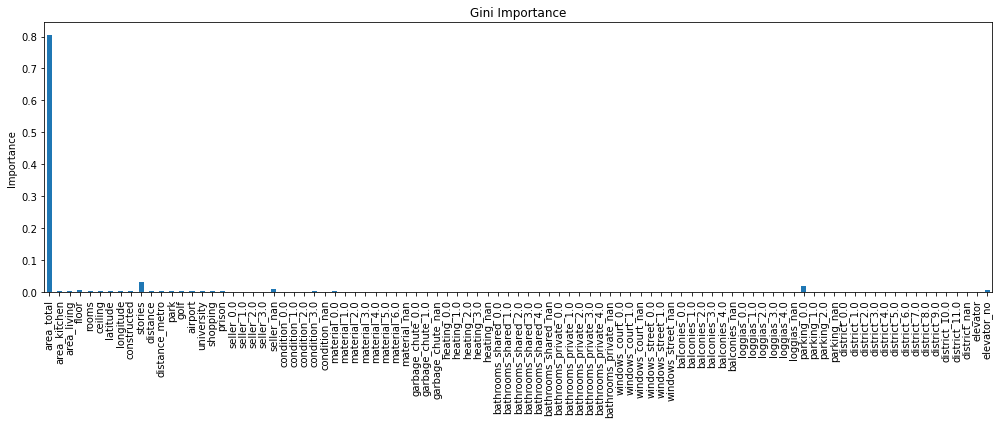

In [38]:
importances = modelRF.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run RandomForest on category_2/5

In [39]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [40]:
modelRF = RandomForestRegressor(n_estimators=382,
                                max_depth=None,
                                #min_samples_split=min_samples_split,
                                #min_samples_leaf=min_samples_leaf,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=8147,
                                min_impurity_decrease=0.0,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=None,
                                random_state=42,
                                verbose=0,
                                warm_start=False,
                                ccp_alpha=0.0,
                                max_samples=None)

modelRF.fit(X_train, y_train)
prediction = modelRF.predict(X_test)
mse = round(mean_squared_error(prediction, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.01271
Test RMSE:  0.11273863579093017


Text(0, 0.5, 'Ground Truth')

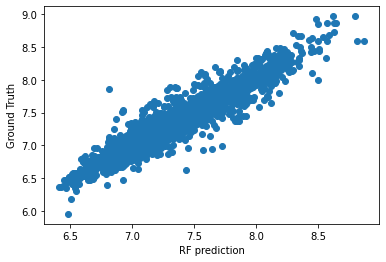

In [41]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('RF prediction')
plt.ylabel('Ground Truth')

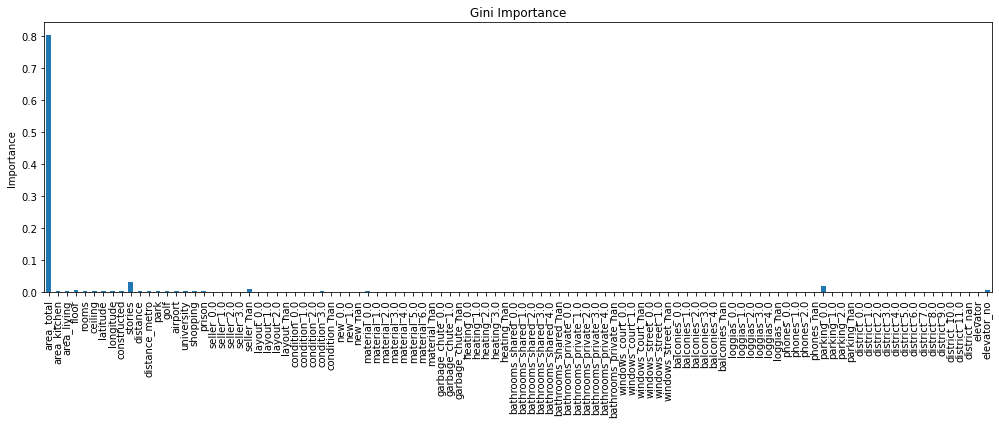

In [42]:
importances = modelRF.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run AdaBoost

# AdaBoost on category_4

In [43]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [44]:
modelADAB = AdaBoostRegressor(n_estimators=748,
                              learning_rate=0.011258696251195402,
                              loss='square',
                              random_state=42)

modelADAB.fit(X_train, y_train)
prediction = modelADAB.predict(X_test)
mse = round(mean_squared_error(prediction, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.03062
Test RMSE:  0.17498571370257632


Text(0, 0.5, 'Ground Truth')

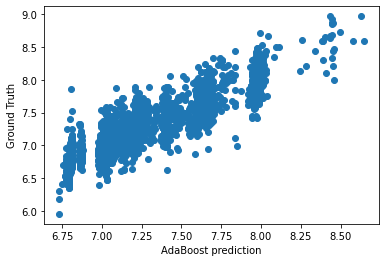

In [45]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('AdaBoost prediction')
plt.ylabel('Ground Truth')

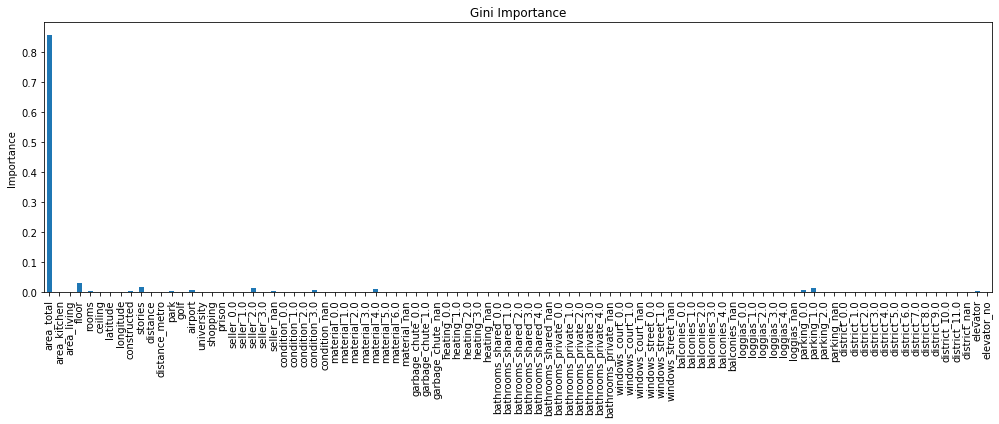

In [46]:
importances = modelADAB.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# AdaBoost on category_2/5

In [47]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [48]:
modelADAB = AdaBoostRegressor(n_estimators=668,
                              learning_rate=0.01694216428470028,
                              loss='square',
                              random_state=42)

modelADAB.fit(X_train, y_train)
prediction = modelADAB.predict(X_test)
mse = round(mean_squared_error(prediction, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.0304
Test RMSE:  0.17435595774162693


Text(0, 0.5, 'Ground Truth')

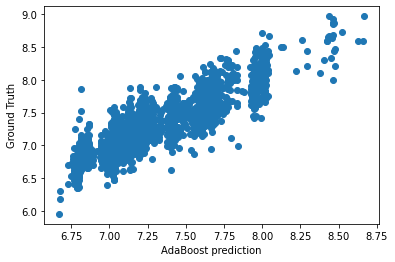

In [49]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('AdaBoost prediction')
plt.ylabel('Ground Truth')

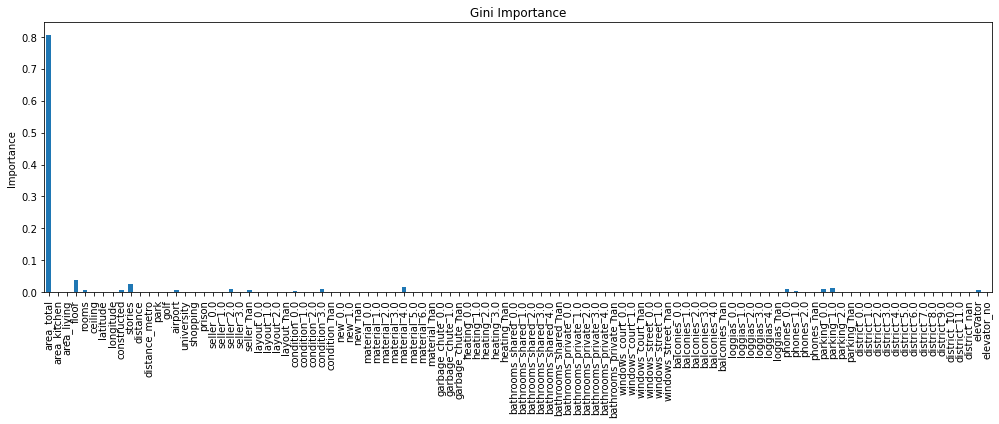

In [50]:
importances = modelADAB.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# True Stacking using category_5 data

In [51]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [52]:
# Settings from Vlads notebook

ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS,
           shuffle=True,
           random_state=SEED
           ) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [53]:
# Test META_MODEL splitting training data

# Use my optimized on complete category_5 data
lgbm_regressor = lgb.LGBMRegressor(num_leaves=72,
                                   max_depth=79, 
                                   random_state=42,
                                   metric='rmse',
                                   n_jobs=4, 
                                   n_estimators=4059,
                                   colsample_bytree=0.5924522364267432,
                                   subsample=0.9984269177996842,
                                   learning_rate=0.04557246091996505)

dt_oof_train, dt_oof_test = get_oof(lgbm_regressor, X_train.values, y_train.values.ravel(), X_test.values)
print('All predictions for train set:', len(dt_oof_train))
print('All predictions for test set:', len(dt_oof_test))

All predictions for train set: 18628
All predictions for test set: 4657


In [54]:
# Uses optimized models on category_5 data

# Updated
xgboost_regressor = xgboost.XGBRegressor(base_score=0.7041494982916056, 
                                         booster='gbtree', 
                                         colsample_bylevel=1,
                                         colsample_bynode=1, 
                                         colsample_bytree=0.7124067309329056,
                                         gamma=0, 
                                         gpu_id=-1, 
                                         importance_type=None,
                                         interaction_constraints='',
                                         learning_rate=0.03581837931328673, 
                                         max_delta_step=0,
                                         max_depth=12, 
                                         min_child_weight=7,
                                         monotone_constraints='()', 
                                         n_estimators=1731, 
                                         n_jobs=16,
                                         num_parallel_tree=1, 
                                         predictor='auto', 
                                         random_state=42, 
                                         reg_alpha=0,
                                         reg_lambda=1, 
                                         scale_pos_weight=1, 
                                         subsample=0.8941570357029943, 
                                         tree_method='exact',
                                         validate_parameters=1, 
                                         verbosity=None, 
                                         objective='reg:squarederror',
                                         enable_categorical=False)

# Updated
catboost_regressor = CatBoostRegressor(n_estimators=2343,
                                       learning_rate=0.058500478169372754,
                                       thread_count=-1,
                                       depth=12,
                                       silent=True,
                                       random_seed=42,
                                       bagging_temperature=0.08070463240695834)
# Updated
rf_regressor = RandomForestRegressor(n_estimators=382,
                                     max_depth=None,
                                     #min_samples_split=min_samples_split,
                                     #min_samples_leaf=min_samples_leaf,
                                     min_weight_fraction_leaf=0.0,
                                     max_features='auto',
                                     max_leaf_nodes=8147,
                                     min_impurity_decrease=0.0,
                                     bootstrap=True,
                                     oob_score=False,
                                     n_jobs=None,
                                     random_state=42,
                                     verbose=0,
                                     warm_start=False,
                                     ccp_alpha=0.0,
                                     max_samples=None)

In [55]:
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_regressor, X_train.values, y_train.values.ravel(), X_test.values)
xgb_oof_train, xgb_oof_test = get_oof(xgboost_regressor, X_train.values, y_train.values.ravel(), X_test.values)
cat_oof_train, cat_oof_test = get_oof(catboost_regressor, X_train.values, y_train.values.ravel(), X_test.values)
rf_oof_train, rf_oof_test = get_oof(rf_regressor, X_train.values, y_train.values.ravel(), X_test.values)

In [56]:
x_train = np.concatenate((
    lgbm_oof_train,
    xgb_oof_train,
    cat_oof_train,
    rf_oof_train
), axis=1)

x_test = np.concatenate((
    lgbm_oof_test,
    xgb_oof_test,
    cat_oof_test,
    rf_oof_test
), axis=1)

In [57]:
META_MODEL = lgb.LGBMRegressor(num_leaves=5,
                               max_depth=7, 
                               random_state=SEED, 
                               silent=True, 
                               metric='rmse',
                               n_jobs=4, 
                               n_estimators=200,
                               colsample_bytree=1,
                               subsample=0.9,
                               learning_rate=0.05)

META_MODEL.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=1, learning_rate=0.05, max_depth=7,
              metric='rmse', n_estimators=200, n_jobs=4, num_leaves=5,
              random_state=42, subsample=0.9)

In [59]:
final_predictions = META_MODEL.predict(x_test)

In [60]:
mse = round(mean_squared_error(final_predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.00892
Test RMSE:  0.09444575162494076


Text(0, 0.5, 'Ground Truth')

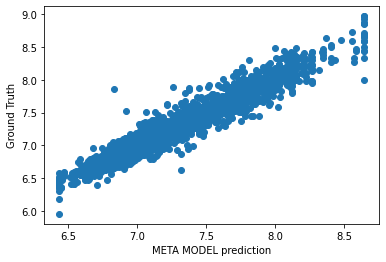

In [61]:
# Plot model performance (done on splitting test data)
plt.scatter(final_predictions, y_test)
plt.xlabel('META MODEL prediction')
plt.ylabel('Ground Truth')

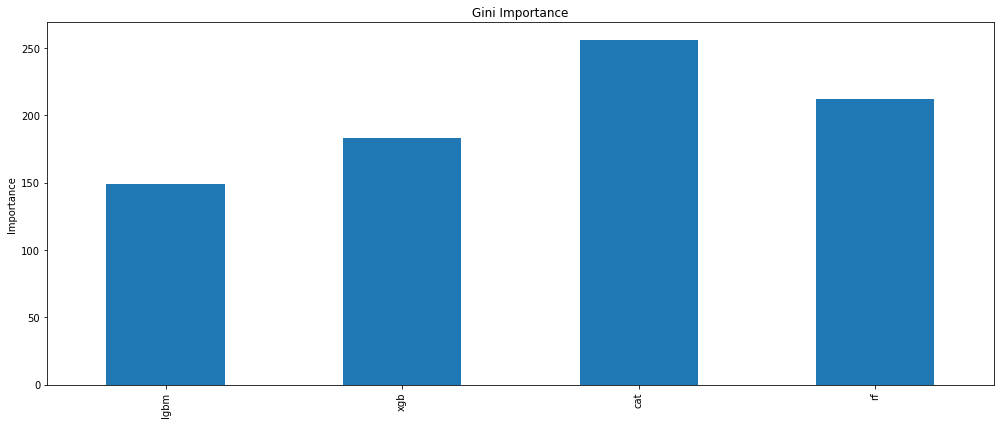

In [62]:
importances = META_MODEL.feature_importances_
importances = pd.Series(importances, index=["lgbm", "xgb", "cat", "rf"])

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run META_MODEL on training data

In [63]:
# Run on complete data 
X_train = D4_train.copy()
X_test = D4_test.copy()
Y = y_train_4.copy()

In [64]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS,
           shuffle=True,
           random_state=SEED
           ) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [65]:
dt_oof_train, dt_oof_test = get_oof(lgbm_regressor, X_train.values, Y.values.ravel(), X_test)
print('All predictions for train set:', len(dt_oof_train))
print('All predictions for test set:', len(dt_oof_test))

All predictions for train set: 23285
All predictions for test set: 9937


In [66]:
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_regressor, X_train.values, Y.values.ravel(), X_test)
xgb_oof_train, xgb_oof_test = get_oof(xgboost_regressor, X_train.values, Y.values.ravel(), X_test)
cat_oof_train, cat_oof_test = get_oof(catboost_regressor, X_train.values, Y.values.ravel(), X_test)
rf_oof_train, rf_oof_test = get_oof(rf_regressor, X_train.values, Y.values.ravel(), X_test)

In [67]:
x_train = np.concatenate((
    lgbm_oof_train,
    xgb_oof_train,
    cat_oof_train,
    rf_oof_train
), axis=1)

x_test = np.concatenate((
    lgbm_oof_test,
    xgb_oof_test,
    cat_oof_test,
    rf_oof_test
), axis=1)

In [68]:
META_MODEL_FINAL = lgb.LGBMRegressor(num_leaves=5,
                                     max_depth=7, 
                                     random_state=SEED, 
                                     silent=True, 
                                     metric='rmse',
                                     n_jobs=4, 
                                     n_estimators=200,
                                     colsample_bytree=1,
                                     subsample=0.9,
                                     learning_rate=0.05)

META_MODEL_FINAL.fit(X_train, Y)

LGBMRegressor(colsample_bytree=1, learning_rate=0.05, max_depth=7,
              metric='rmse', n_estimators=200, n_jobs=4, num_leaves=5,
              random_state=42, subsample=0.9)

In [70]:
kaggle_predictions = META_MODEL_FINAL.predict(X_test)

In [71]:
# IF only log prices
"""
submission = pd.DataFrame(df_test_4["id"])
submission["price_prediction"] =  np.exp(kaggle_predictions)
submission.to_csv("predictions_META_MODEL.csv", index=False)
df = pd.read_csv("predictions_META_MODEL.csv")
df.shape
df.head()
"""

'\nsubmission = pd.DataFrame(df_test_4["id"])\nsubmission["price_prediction"] =  np.exp(kaggle_predictions)\nsubmission.to_csv("predictions_META_MODEL.csv", index=False)\ndf = pd.read_csv("predictions_META_MODEL.csv")\ndf.shape\ndf.head()\n'

In [72]:
submission = pd.DataFrame(df_test_4["id"])

# If ln prices - revert:
#submission["price_prediction"] =  np.exp(kaggle_predictions)

# If log10 prices - revert:
submission["price_prediction"] = np.power(10, kaggle_predictions)

submission.to_csv("predictions_META_MODEL.csv", index=False)
df = pd.read_csv("predictions_META_MODEL.csv")
df.shape
df.head()

,id,price_prediction
0,23285,1.385264e+07
1,23286,1.486369e+07
2,23287,7.425345e+06
3,23288,1.179462e+07
4,23289,6.761194e+06
